#***Workshop Registros Clínicos de Insuficiencia Cardíaca***

Las enfermedades cardiovasculares causan cerca de 17 millones de muertes anuales, principalmente por infartos de miocardio e insuficiencia cardíaca (IC), condición en la que el corazón no bombea suficiente sangre. Los registros médicos electrónicos facilitan recopilar síntomas, características y valores de laboratorio, permitiendo análisis bioestadísticos que detectan patrones invisibles en la práctica clínica. La inteligencia artificial potencia este proceso al predecir la evolución y supervivencia de los pacientes con IC, además de identificar factores clave para optimizar prevención y tratamiento.

El conjunto de datos incluye las siguientes variables: age (edad, entero, años), anaemia (binaria, presencia de anemia), creatinine_phosphokinase (CPK, entero, mcg/L), diabetes (binaria), ejection_fraction (fracción de eyección, entero, %), high_blood_pressure (binaria), platelets (plaquetas, continua, kiloplaquetas/mL), serum_creatinine (creatinina sérica, continua, mg/dL), serum_sodium (sodio sérico, entero, mEq/L), sex (binaria, mujer u hombre), smoking (binaria), time (entero, días de seguimiento), y DEATH_EVENT (binaria, variable objetivo). Todas las variables están completas, sin valores faltantes.

Se realizaron análisis bioestadísticos tradicionales para comparar resultados. Ambos enfoques identificaron la creatinina sérica y la fracción de eyección como los factores de riesgo más significativos, sobre los cuales se construyeron los modelos de predicción de supervivencia.


In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
!pip install plotly

In [ ]:
data = pd.read_csv("H.csv", encoding='latin1', on_bad_lines='skip')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
data.info()
data.isnull().sum()
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


,0
age,47
anaemia,2
creatinine_phosphokinase,208
diabetes,2
ejection_fraction,17
high_blood_pressure,2
platelets,176
serum_creatinine,40
serum_sodium,27
sex,2


# 📑 Diccionario de Datos – Registros Clínicos de Insuficiencia Cardíaca

| Nombre de Variable       | Rol     | Tipo       | Demográfico | Descripción                                               | Unidades          | Valores Faltantes |
|--------------------------|---------|------------|-------------|-----------------------------------------------------------|-------------------|-------------------|
| age                      | Feature | Entero     | Edad        | Edad del paciente                                         | años              | no                |
| anaemia                  | Feature | Binaria    |             | Disminución de glóbulos rojos o hemoglobina               |                   | no                |
| creatinine_phosphokinase | Feature | Entero     |             | Nivel de la enzima CPK en la sangre                       | mcg/L             | no                |
| diabetes                 | Feature | Binaria    |             | Indica si el paciente tiene diabetes                      |                   | no                |
| ejection_fraction        | Feature | Entero     |             | Porcentaje de sangre expulsada del corazón por contracción| %                 | no                |
| high_blood_pressure      | Feature | Binaria    |             | Indica si el paciente tiene hipertensión                  |                   | no                |
| platelets                | Feature | Continua   |             | Plaquetas en la sangre                                    | kiloplaquetas/mL  | no                |
| serum_creatinine         | Feature | Continua   |             | Nivel de creatinina sérica en la sangre                   | mg/dL             | no                |
| serum_sodium             | Feature | Entero     |             | Nivel de sodio sérico en la sangre                        | mEq/L             | no                |
| sex                      | Feature | Binaria    | Sexo        | Mujer u hombre                                            |                   | no                |
| smoking                  | Feature | Binaria    |             | Indica si el paciente fuma                                |                   | no                |
| time                     | Feature | Entero     |             | Tiempo de seguimiento del paciente                        | días              | no                |
| DEATH_EVENT              | Target  | Binaria    |             | Indica si el paciente falleció durante el seguimiento     |                   | no                |


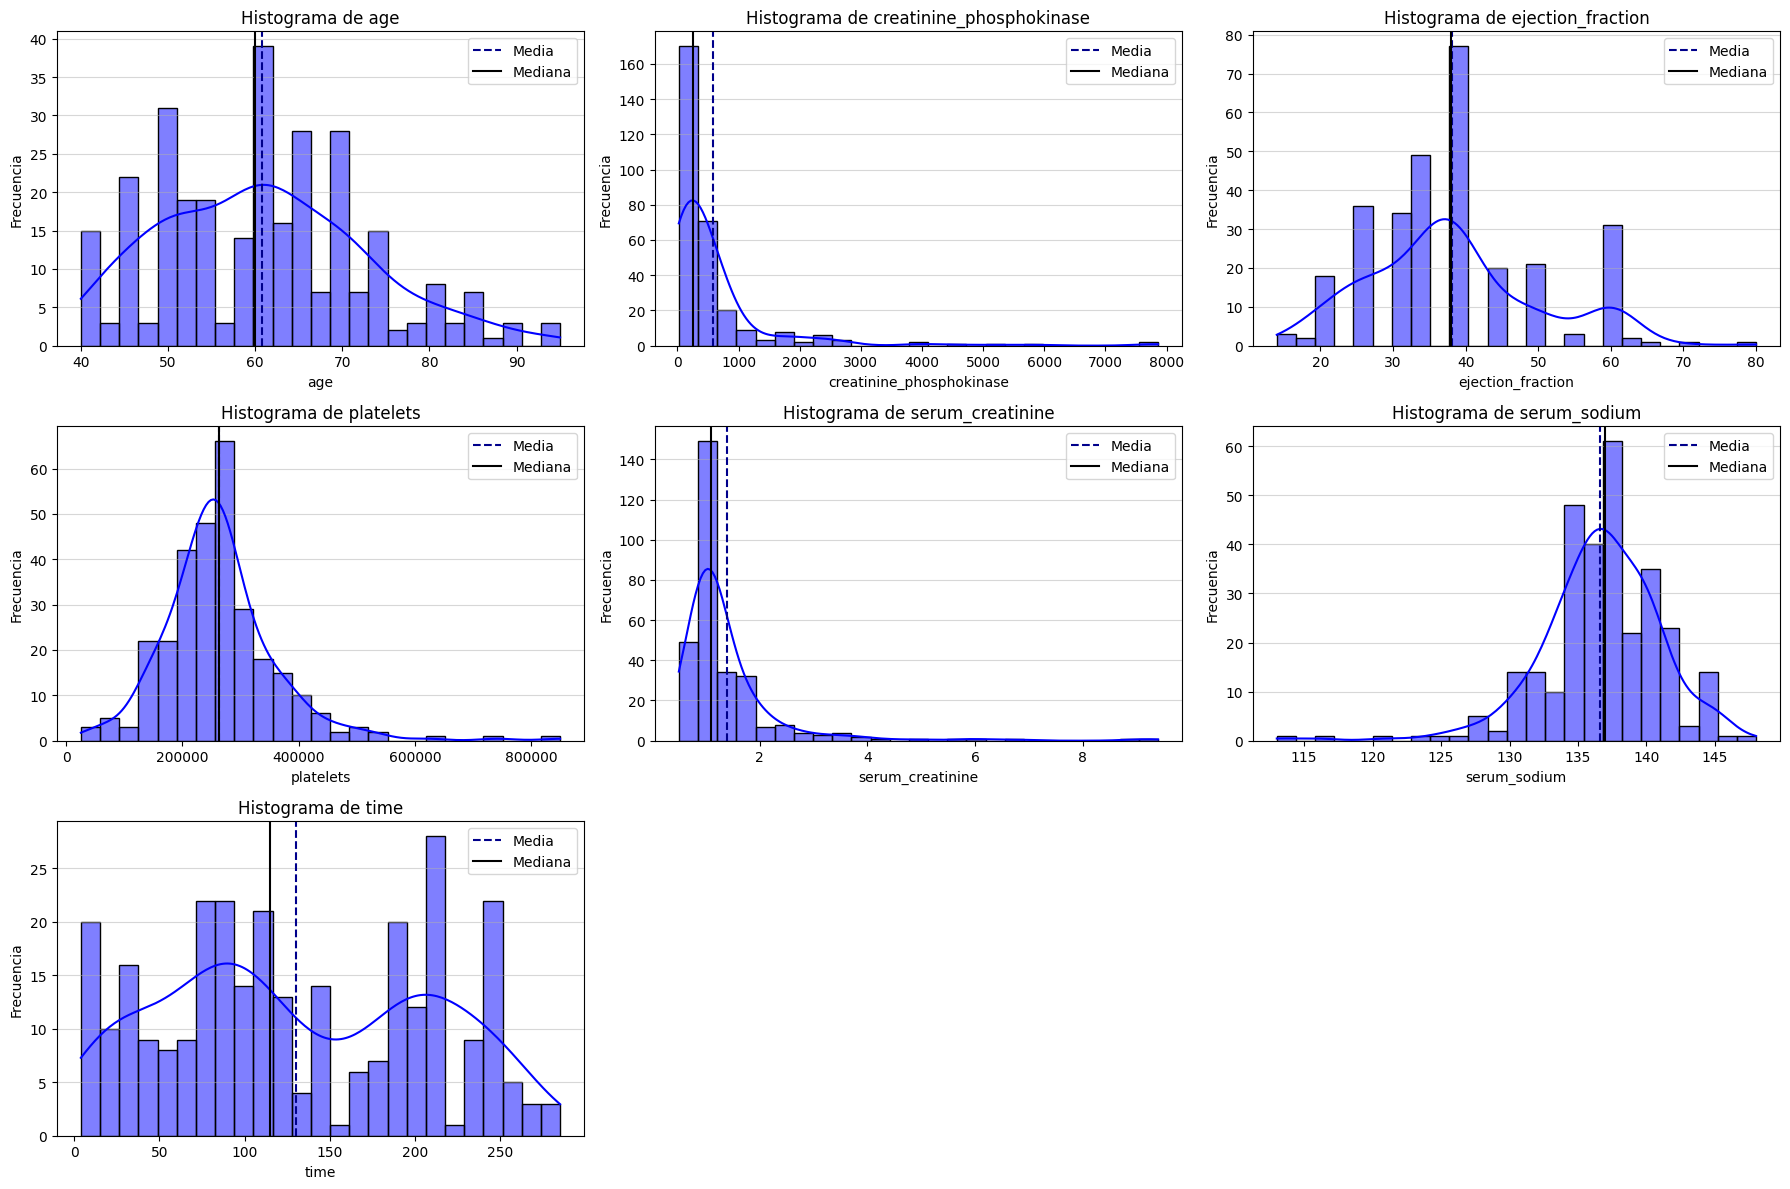

In [ ]:
# Variables numéricas
numerical_vars = ["age", "creatinine_phosphokinase", "ejection_fraction",
                  "platelets", "serum_creatinine", "serum_sodium", "time"]

# Subplots dinámicos según número de variables
fig, axes = plt.subplots(nrows=len(numerical_vars)//3 + 1, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_vars):
    # Histograma con KDE (Seaborn)
    sns.histplot(data[col], bins=25, kde=True, color='blue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(axis='y', alpha=0.5)

    # Líneas de media y mediana
    axes[i].axvline(data[col].mean(), color='darkblue', linestyle='--', label='Media')
    axes[i].axvline(data[col].median(), color='black', linestyle='-', label='Mediana')
    axes[i].legend()

# Ocultar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


/tmp/ipython-input-2302032513.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="DEATH_EVENT", y=feature, data=data, palette=palette)
/tmp/ipython-input-2302032513.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="DEATH_EVENT", y=feature, data=data, palette=palette)
/tmp/ipython-input-2302032513.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="DEATH_EVENT", y=feature, data=data, palette=palette)
/tmp/ipython-input-2302032513.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

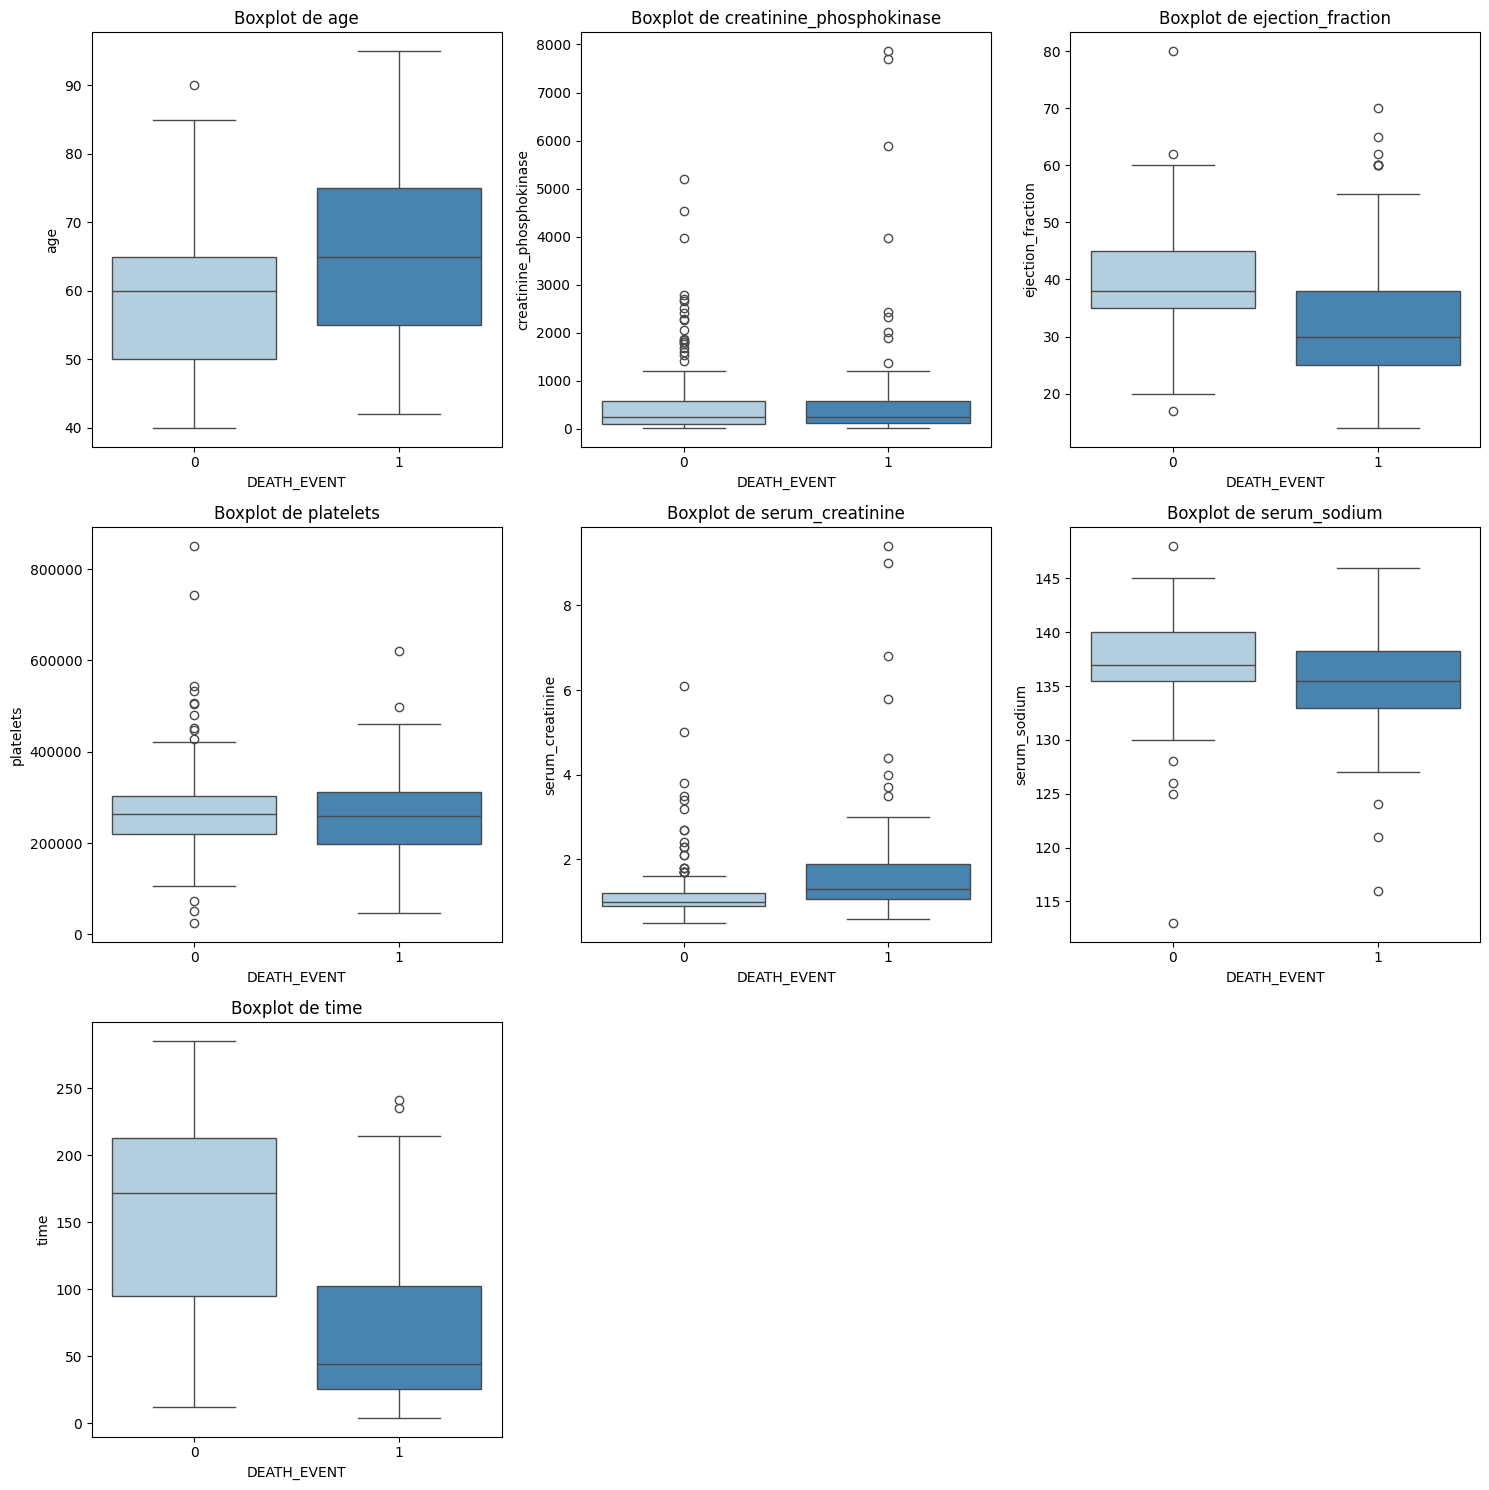

In [ ]:
# Lista de variables numéricas
numericos = ["age", "creatinine_phosphokinase", "ejection_fraction",
             "platelets", "serum_creatinine", "serum_sodium", "time"]

# Paleta personalizada
palette = sns.color_palette("Blues", n_colors=len(data['DEATH_EVENT'].unique()))

# Definir grid dinámico
n = len(numericos)
rows = int(np.ceil(n / 3))
cols = 3

plt.figure(figsize=(15, 5 * rows))

for i, feature in enumerate(numericos):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x="DEATH_EVENT", y=feature, data=data, palette=palette)
    plt.title(f"Boxplot de {feature}")

plt.tight_layout()
plt.show()


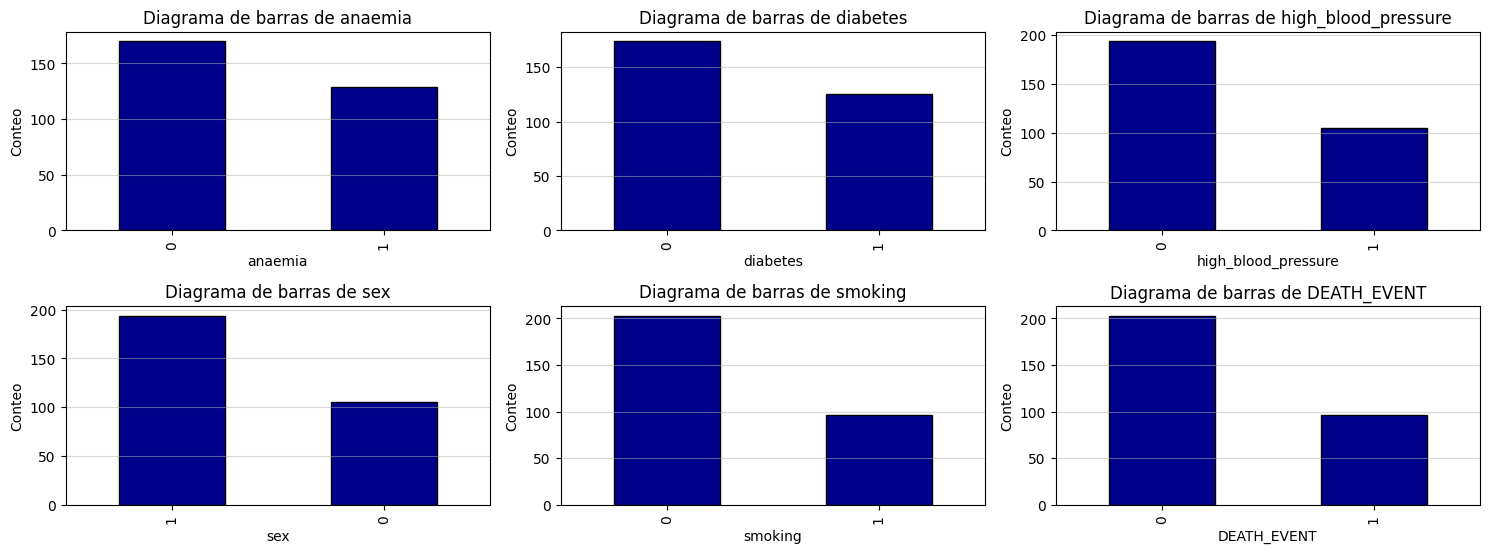

In [ ]:
# Variables categóricas
categorical_vars = ["anaemia", "diabetes", "high_blood_pressure",
                    "sex", "smoking", "DEATH_EVENT"]

fig, axes = plt.subplots(nrows=len(categorical_vars)//3 + 1, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    data[col].value_counts().plot(kind='bar', ax=axes[i], color='darkblue', edgecolor='black')
    axes[i].set_title(f'Diagrama de barras de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Conteo')
    axes[i].grid(axis='y', alpha=0.5)

# Ocultar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
desc = data.describe().T
desc.drop(index=categorical_vars, inplace=True)
desc

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
time,299.0,130.260870,77.614208,4.0,73.0,115.0,203.0,285.0


In [ ]:
# Resumen: Descriptivo variables categoricas
summary_cat = {}

for col in categorical_vars:
    counts = data[col].value_counts()
    perc = data[col].value_counts(normalize=True) * 100
    summary_cat[col] = {
        'Conteo valores 0': counts.get(0, 0),
        'Conteo valores 1': counts.get(1, 0),
        'Porcentaje No': round(perc.get(0, 0), 2),
        'Porcentaje Si': round(perc.get(1, 0), 2)
    }

import pandas as pd
summary_cat = pd.DataFrame(summary_cat).T
summary_cat


,Conteo valores 0,Conteo valores 1,Porcentaje No,Porcentaje Si
anaemia,170.0,129.0,56.86,43.14
diabetes,174.0,125.0,58.19,41.81
high_blood_pressure,194.0,105.0,64.88,35.12
sex,105.0,194.0,35.12,64.88
smoking,203.0,96.0,67.89,32.11
DEATH_EVENT,203.0,96.0,67.89,32.11


# **Resumen estadístico descriptivo**

La muestra incluye en un conjunto de datos de 299 pacientes con insuficiencia cardíaca. La edad promedio es de 60.8 años, con un rango entre 40 y 95 años, lo que refleja una población predominantemente adulta y mayor. En cuanto a comorbilidades, el 43 % presenta anemia, el 42 % diabetes y el 35 % hipertensión, condiciones que son factores de riesgo importantes en la evolución clínica.

La fracción de eyección tiene una media de 38 %, con valores tan bajos como 14 %; cifras reducidas de este parámetro indican insuficiencia cardíaca grave. Los niveles de plaquetas presentan gran variabilidad, desde 25,100 hasta 850,000, lo que sugiere distintos perfiles hematológicos. La creatinina sérica muestra un promedio de 1.39 mg/dL, pero con un máximo de 9.4, indicando presencia de disfunción renal en algunos pacientes. El sodio sérico se mantiene cercano a lo normal (136.6 mEq/L), aunque existen casos con hiponatremia.

En términos demográficos, el 65 % de los pacientes son hombres y el 32 % son fumadores. El tiempo de seguimiento medio fue de 130 días, y la variable objetivo muestra que 32 % de los pacientes fallecieron durante ese período.

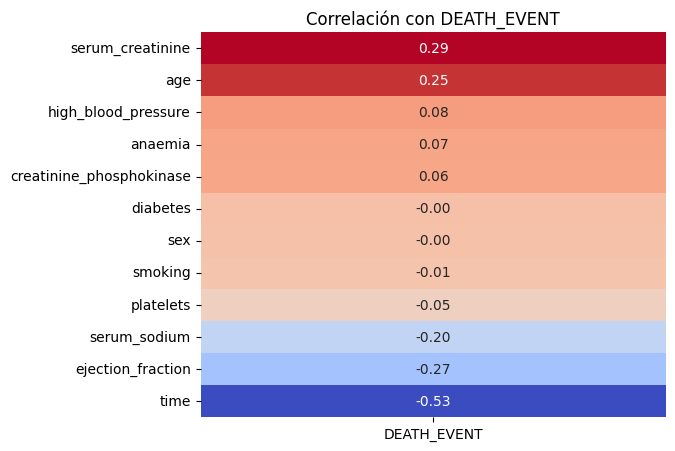

In [ ]:
# 1️⃣ Correlación con DEATH_EVENT
plt.figure(figsize=(6, 5))
corr_target = data.corr(numeric_only=True).drop("DEATH_EVENT", axis=0)[["DEATH_EVENT"]].sort_values(by="DEATH_EVENT", ascending=False)
sns.heatmap(corr_target, annot=True, cmap="coolwarm", cbar=False, fmt=".2f")
plt.title("Correlación con DEATH_EVENT")
plt.show()



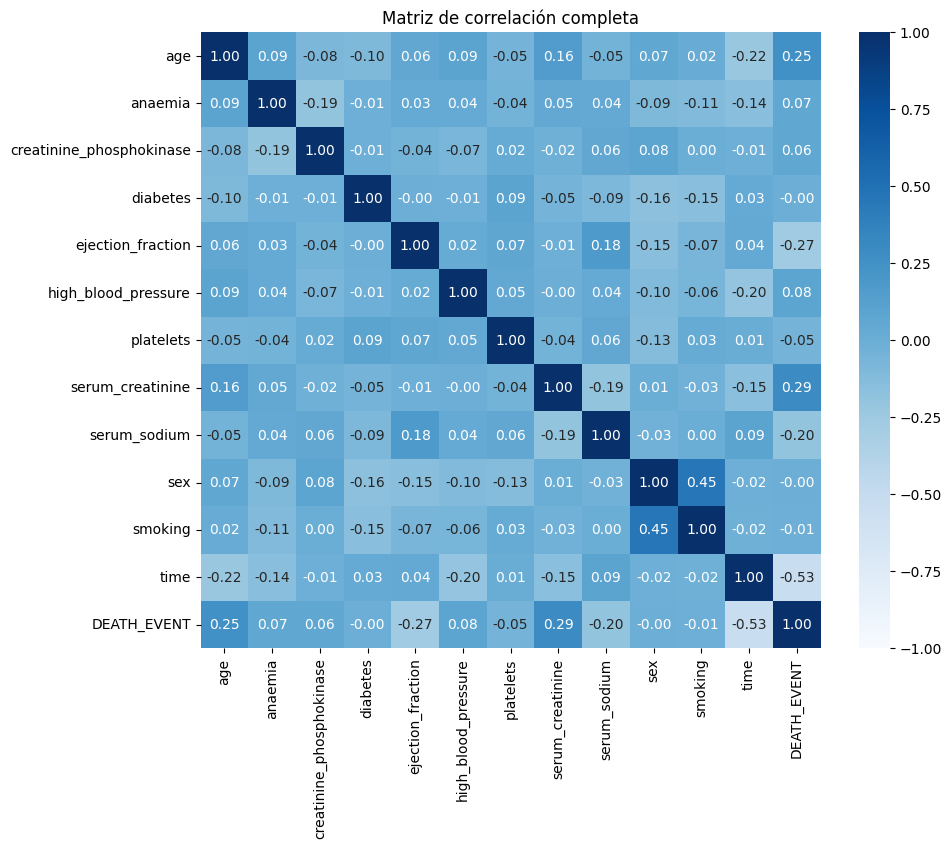

In [ ]:
# 2️⃣ Matriz de correlación completa (todas las numéricas)
plt.figure(figsize=(10, 8))
corr_matrix = data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title("Matriz de correlación completa")
plt.show()

La matriz de correlación muestra la relación entre variables clínicas y la variable objetivo DEATH_EVENT. Se observa que la fracción de eyección (-0.27) y el tiempo de seguimiento (-0.53) tienen correlaciones negativas moderadas con la muerte, es decir, valores bajos se asocian con mayor mortalidad. En cambio, la creatinina sérica (0.29) y la edad (0.25) presentan correlaciones positivas, lo que indica mayor riesgo con valores elevados. El resto de variables exhiben correlaciones débiles, sugiriendo influencia limitada.

In [ ]:
# Crear subconjuntos
critico = data[data["DEATH_EVENT"] == 1].copy()
recuperacion = data[data["DEATH_EVENT"] == 0].copy()

# Mostrar tamaños de cada grupo
print("Pacientes críticos (DEATH_EVENT=1):", critico.shape[0], "equivalente al 32,4%.")

print("Pacientes en recuperación (DEATH_EVENT=0):", recuperacion.shape[0], "equivalente al 67,6%.")

# Opcional: guardar en archivos separados
critico.to_csv("critico.csv", index=False)
recuperacion.to_csv("recuperacion.csv", index=False)





Pacientes críticos (DEATH_EVENT=1): 96 equivalente al 32,4%.
Pacientes en recuperación (DEATH_EVENT=0): 203 equivalente al 67,6%.


## Varibles que se escogieron por Correlacion


In [ ]:
# Variables significativas a analizar
significant_vars = ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']

# Realizar pruebas de Mann-Whitney U para cada variable
print("\nResultados de las pruebas de hipótesis (Mann-Whitney U):")
print("--------------------------------------------------------")
for var in significant_vars:
    stat, p_value = stats.mannwhitneyu(critico[var], recuperacion[var])
    print(f"{var}:")
    print(f"  Estadístico = {stat:.3f}")
    print(f"  p-valor = {p_value:.4f}")
    print(f"  Significativo (α=0.05): {'Sí' if p_value < 0.05 else 'No'}")
    print()

# Estadísticas descriptivas por grupo
print("\nEstadísticas descriptivas por grupo:")
print("-----------------------------------")
for var in significant_vars:
    print(f"\n{var}:")
    print("Pacientes críticos (DEATH_EVENT=1):")
    print(f"  Media: {critico[var].mean():.2f}")
    print(f"  Mediana: {critico[var].median():.2f}")
    print(f"  Desviación estándar: {critico[var].std():.2f}")
    print("Pacientes en recuperación (DEATH_EVENT=0):")
    print(f"  Media: {recuperacion[var].mean():.2f}")
    print(f"  Mediana: {recuperacion[var].median():.2f}")
    print(f"  Desviación estándar: {recuperacion[var].std():.2f}")

# Opcional: guardar en archivos separados
critico.to_csv("critico.csv", index=False)
recuperacion.to_csv("recuperacion.csv", index=False)


Resultados de las pruebas de hipótesis (Mann-Whitney U):
--------------------------------------------------------
age:
  Estadístico = 12367.000
  p-valor = 0.0002
  Significativo (α=0.05): Sí

ejection_fraction:
  Estadístico = 6311.500
  p-valor = 0.0000
  Significativo (α=0.05): Sí

serum_creatinine:
  Estadístico = 14190.000
  p-valor = 0.0000
  Significativo (α=0.05): Sí

serum_sodium:
  Estadístico = 7226.500
  p-valor = 0.0003
  Significativo (α=0.05): Sí


Estadísticas descriptivas por grupo:
-----------------------------------

age:
Pacientes críticos (DEATH_EVENT=1):
  Media: 65.22
  Mediana: 65.00
  Desviación estándar: 13.21
Pacientes en recuperación (DEATH_EVENT=0):
  Media: 58.76
  Mediana: 60.00
  Desviación estándar: 10.64

ejection_fraction:
Pacientes críticos (DEATH_EVENT=1):
  Media: 33.47
  Mediana: 30.00
  Desviación estándar: 12.53
Pacientes en recuperación (DEATH_EVENT=0):
  Media: 40.27
  Mediana: 38.00
  Desviación estándar: 10.86

serum_creatinine:
Pacientes 

/tmp/ipython-input-2192277953.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="DEATH_EVENT", y=feature, data=critico, palette=palette)
/tmp/ipython-input-2192277953.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="DEATH_EVENT", y=feature, data=critico, palette=palette)
/tmp/ipython-input-2192277953.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="DEATH_EVENT", y=feature, data=critico, palette=palette)
/tmp/ipython-input-2192277953.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be

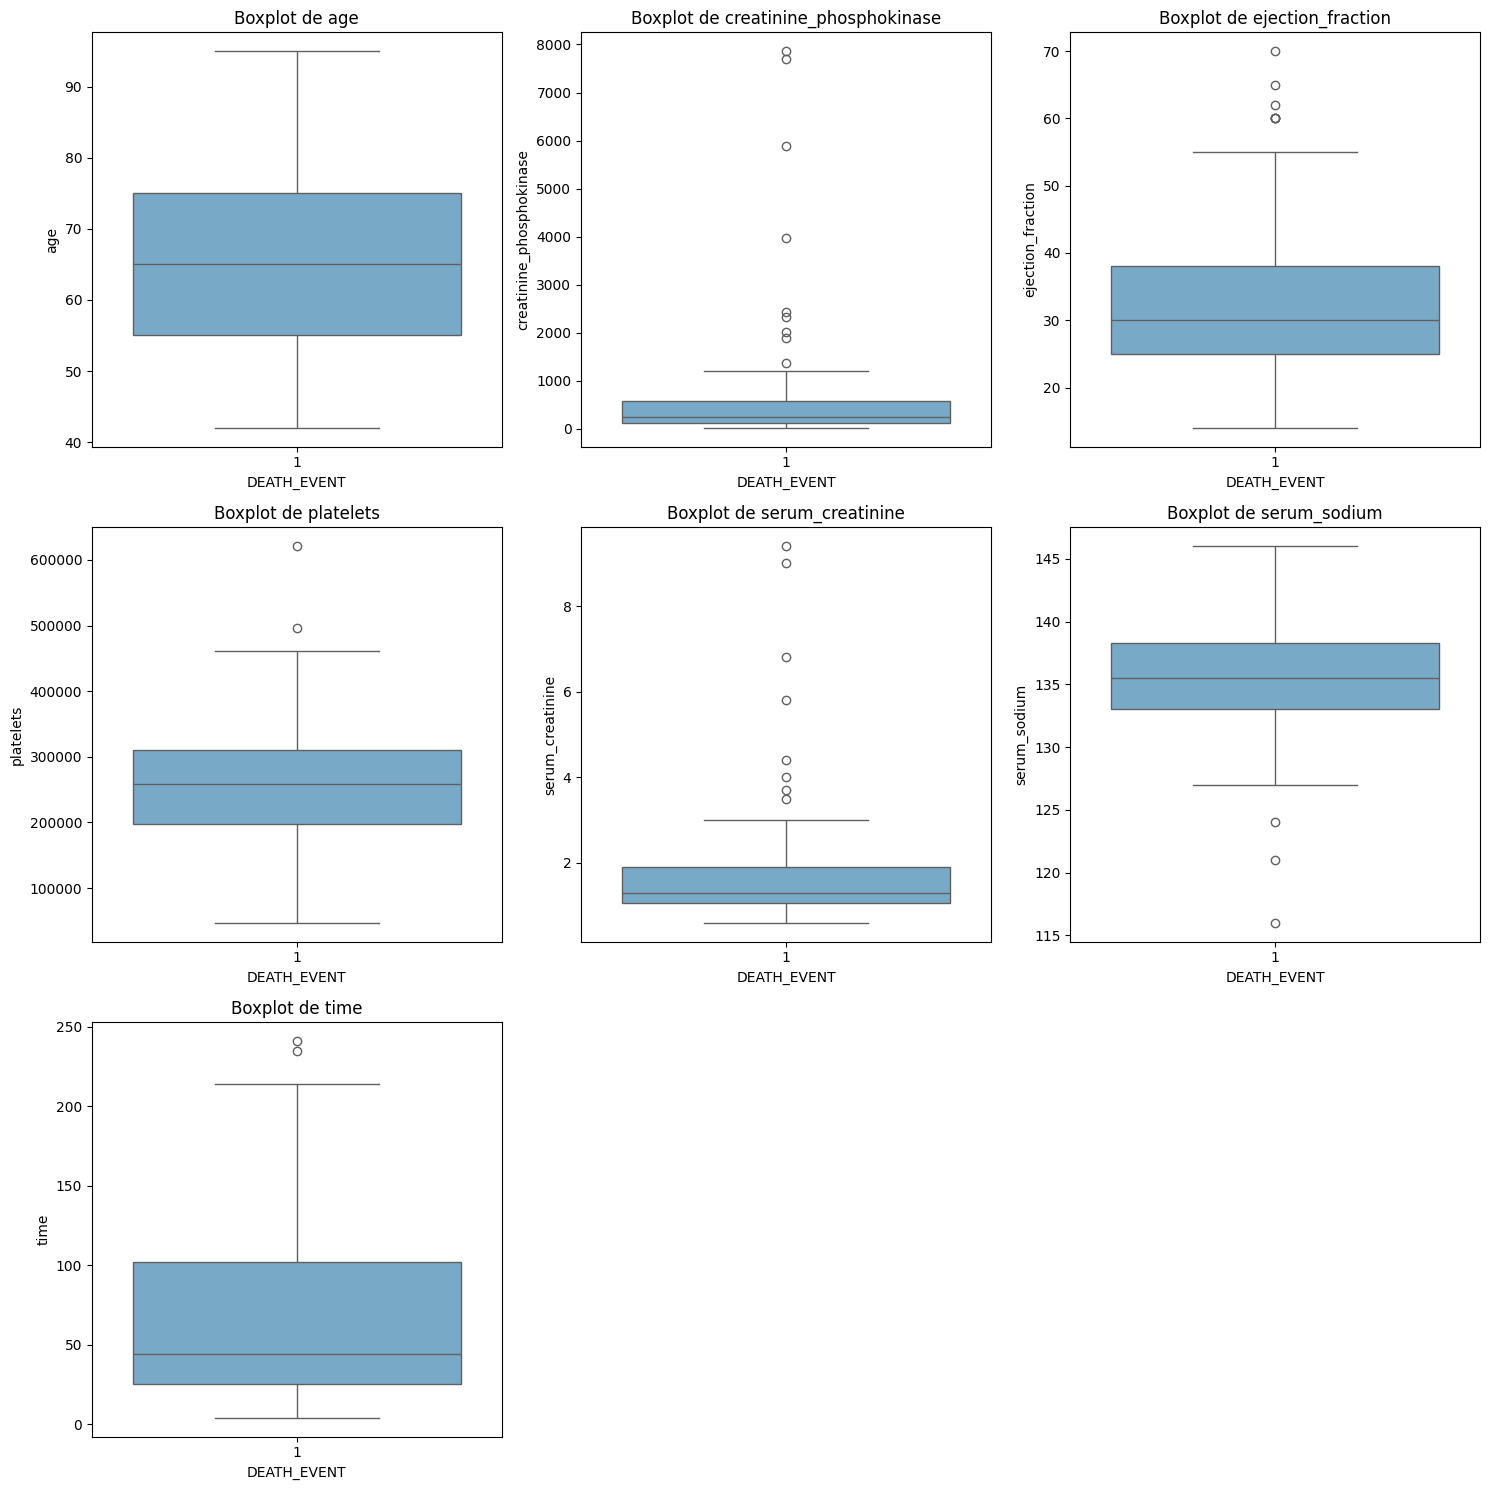

In [ ]:
# Lista de variables numéricas
numericos = ["age", "creatinine_phosphokinase", "ejection_fraction",
             "platelets", "serum_creatinine", "serum_sodium", "time"]

# Paleta personalizada
palette = sns.color_palette("Blues", n_colors=len(critico['DEATH_EVENT'].unique()))

# Definir grid dinámico
n = len(numericos)
rows = int(np.ceil(n / 3))
cols = 3

plt.figure(figsize=(15, 5 * rows))

for i, feature in enumerate(numericos):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x="DEATH_EVENT", y=feature, data=critico, palette=palette)
    plt.title(f"Boxplot de {feature}")

plt.tight_layout()
plt.show()


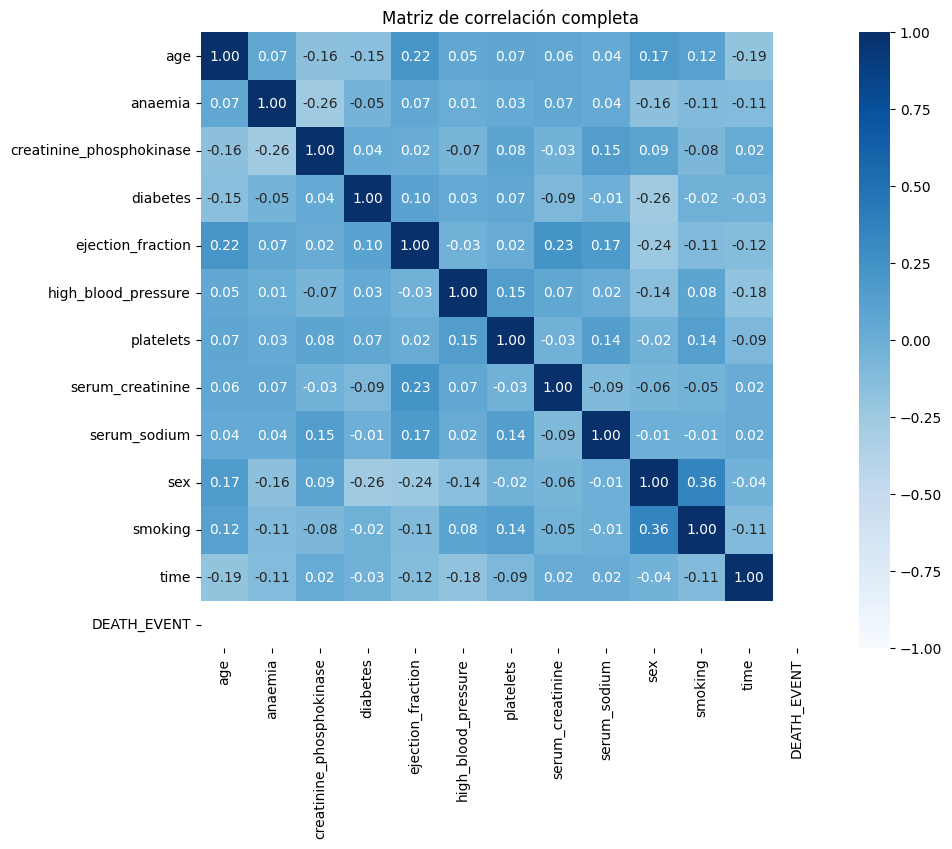

In [ ]:
# 3 Matriz de correlación completa (todas las numéricas)
plt.figure(figsize=(10, 8))
corr_matrix = critico.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title("Matriz de correlación completa")
plt.show()

[
'age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
'ejection_fraction', 'high_blood_pressure', 'platelets',
'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'
]

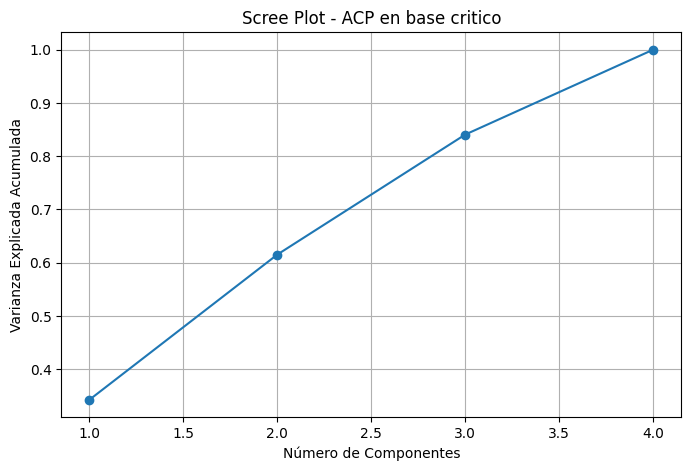

Varianza explicada por componente:
[0.34282093 0.27256335 0.22529542 0.15932031]

Matriz de cargas (loadings):
                        PC1       PC2       PC3       PC4
age                0.504840  0.047991  0.813408 -0.284957
ejection_fraction  0.691514  0.069111 -0.190349  0.693397
serum_creatinine   0.448527 -0.610748 -0.417911 -0.501159
serum_sodium       0.256456  0.787342 -0.357049 -0.432249
Total entropia recogida en los primero 3 eje de retencion es  0.34282093, 0.27256335 y 0.22529542 es 0.8406797. 


In [ ]:
# Variables numéricas que vas a incluir en el ACP
variables = ['age', 'ejection_fraction','serum_creatinine', 'serum_sodium']


X = critico[variables]


# 1. Escalado de variables (media=0, var=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 2. Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


# 3. Varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_


# Gráfico de varianza explicada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Scree Plot - ACP en base critico')
plt.grid()
plt.show()


# 4. Cargar coeficientes (contribución de variables)
loading_matrix = pd.DataFrame(
pca.components_.T,
columns=[f'PC{i+1}' for i in range(len(variables))],
index=variables
)


print("Varianza explicada por componente:")
print(explained_var)


print("\nMatriz de cargas (loadings):")
print(loading_matrix)

print("Total entropia recogida en los primero 3 eje de retencion es  0.34282093, 0.27256335 y 0.22529542 es 0.8406797. ")

Se usa edad, sangre en circulacion por el corazon, nivel de serum con ceratinina y serum sodico. Con 3 dimensiones clínicas subyacentes los IC son:


Gravedad Cardio-Renal y Edad (PC1): El predictor más fuerte de malos outcomes.

Desequilibrio Hidroelectrolítico (PC2): Un marcador de descompensación y pronóstico.

Edad vs. Función Renal (PC3): Una dimensión adicional que matiza la relación entre edad y riñón.



In [ ]:
#  Entropía de los componentes principales
entropy = -np.sum(explained_var * np.log(explained_var))
print(f"Suma de entropía de los 3 componentes: {entropy:.4f}")

# 5. Esfera de correlaciones 3D con Plotly
pcs = pca.components_

# Crear figura
fig = go.Figure()

# Esfera de referencia
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 25)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

fig.add_trace(go.Surface(x=x, y=y, z=z,
                         opacity=0.3,
                         colorscale='Greys',
                         showscale=False,
                         hoverinfo='none'))

# vectores de variables
for i, var in enumerate(variables):
    fig.add_trace(go.Scatter3d(
        x=[0, pcs[0, i]],
        y=[0, pcs[1, i]],
        z=[0, pcs[2, i]],
        mode='lines+markers+text',
        line=dict(color='blue', width=4),
        marker=dict(size=2),
        text=[None, var],
        textposition="top center",
        name=var
    ))

# Configurar el diseño
fig.update_layout(
    title="Esfera de Correlaciones - ACP 3D",
    scene=dict(
        xaxis_title=f"PC1 ({explained_var[0]*100:.1f}% var)",
        yaxis_title=f"PC2 ({explained_var[1]*100:.1f}% var)",
        zaxis_title=f"PC3 ({explained_var[2]*100:.1f}% var)",
        aspectmode='cube'
    ),
    width=800,
    height=800
)

# Mostrar figura
fig.show()

Suma de entropía de los 3 componentes: 1.3497


# Analisis descriptivo de ACP

Gravedad Cardio-Renal y Edad (PC1): PC1 es muy probablemente el mejor predictor. La ciencia ha demostrado una y otra vez que la combinación de edad avanzada, baja fracción de eyección y deterioro renal es uno de los conjuntos de factores más potentes para predecir la mortalidad en IC. Un modelo de machine learning que uses encontraría una fuerte correlación positiva entre una alta puntuación en PC1 y la probabilidad de muerte.

Desequilibrio Hidroelectrolítico (PC2):  La hiponatremia (bajo sodio) es un hallazgo de laboratorio temido por los cardiólogos porque indica una enfermedad neurohormonal avanzada y de difícil manejo. Esperarías que los pacientes con puntuaciones bajas en PC2 (bajo sodio + alta creatinina) tengan una mayor tasa de mortalidad.

Edad vs. Función Renal (PC3): PC3 podría tener menos poder predictivo por sí solo, ya que la edad ya está capturada en gran medida en PC1. Sin embargo, podría ayudar a refinar el modelo.